# Summary
* calculated d values from a cif file downloaded from web
* the d values are consistent with what Ross has used
* the d values are consistent with experimental results of C60 calibration measurement at SEQ

In [1]:
# setup plotting
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
# plt.xkcd() # comment this out for serious science
# plt.rcdefaults()
# useful modules
import os
# ...and, of course, mantid
# from mantid.simpleapi import *

In [3]:
import numpy as np
from mantid import simpleapi as msa

In [4]:
workdir = '/SNS/users/lj7/dv/sns-chops/detcalib/SEQ/'
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/detcalib/SEQ


## Calibration Information
For all of the calibrations there needs to be a "known" lattice constant to calibrate against when determining the tof to dspacing conversion factors. Traditionally at SNS diamond is used for this. Mantid has a facility for [crystal structure and reflections](http://docs.mantidproject.org/nightly/concepts/CrystalStructureAndReflections.html) built in.

In [5]:
from mantid.geometry import CrystalStructure, ReflectionGenerator

In [6]:
!which python

/home/lj7/miniconda2/envs/mcvine/bin/python


In [8]:
# !conda install -y PyCifRW

Fetching package metadata .................
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /home/lj7/miniconda2/envs/mantid:
#
pycifrw                   4.3                      py27_0    conda-forge


In [11]:
tmp = msa.CreateSampleWorkspace()
msa.LoadCIF(tmp, './C60_RT.cif')
c60 = tmp.sample().getCrystalStructure()

In [12]:
generator = ReflectionGenerator(c60)
dvalues = generator.getDValues(generator.getUniqueHKLs(2,10.))
print dvalues

[8.17528,7.08,5.00632,4.08764,4.2694,3.24853,2.72509,3.54,3.16627,2.8904,2.50316,2.36,2.04382,2.72509,2.39348,2.15938,2.36,2.23889,2.1347]


In [13]:
dvalues = np.array(dvalues)
dvalues = np.array(dvalues*1e8, dtype=int)/1e8
dvalues = np.unique(dvalues)
dvalues

array([ 2.04381995,  2.13470031,  2.15937975,  2.23889258,  2.36      ,
        2.39347684,  2.503158  ,  2.72509327,  2.89039789,  3.16627225,
        3.24852679,  3.54      ,  4.0876399 ,  4.26940063,  5.00631601,
        7.08      ,  8.17527981])

### Get d values from exp data

Load data

These does not work! Out of memory

%%time

wkspName='SEQ_130249'

LoadEventAndCompress(Filename="/SNS/SEQ/IPTS-19573/nexus/SEQ_130249.nxs.h5", OutputWorkspace=wkspName,
                     MaxChunkSize=16, FilterBadPulses=25)
CropWorkspace(InputWorkspace=wkspName, OutputWorkspace=wkspName, XMin=300, XMax=16666.7)

In [14]:
nxspath = '/SNS/SEQ/IPTS-19573/nexus/SEQ_130249.nxs.h5'

Don't load events. Save memory. 

In [16]:
ws = msa.LoadEventNexus(
    Filename=nxspath, FilterByTimeStart=0, FilterByTimeStop=0)

Get total measurement time in seconds

In [17]:
run = ws.getRun()
print run.startTime()
print run.endTime()
print (run.endTime() - run.startTime()).total_seconds()

2017-07-12T09:43:01.039138666 
2017-07-12T12:44:41.771048666 
10900


Only load the first 200 seconds

In [18]:
events1 = msa.LoadEventNexus(
    Filename=nxspath, FilterByTimeStart=0, FilterByTimeStop=200)

Convert to I(d)

In [19]:
%%time
I_d = msa.ConvertUnits(InputWorkspace=events1, Target='dSpacing', EMode='Elastic')

CPU times: user 3.64 s, sys: 9.58 s, total: 13.2 s
Wall time: 7.48 s


In [20]:
%%time
I_d = msa.Rebin(InputWorkspace=I_d, Params='1,0.0005,10')

CPU times: user 52 ms, sys: 28 ms, total: 80 ms
Wall time: 78.8 ms


In [21]:
%%time
I_d_s = msa.SumSpectra(InputWorkspace=I_d)

CPU times: user 1.63 s, sys: 3.02 s, total: 4.66 s
Wall time: 4.65 s


These were used to delete workspaces to save memory. but no use
```
msa.DeleteWorkspace(wkspName)
msa.DeleteWorkspace(I_d)
msa.DeleteWorkspace(I_d_s)
```


Plot

In [22]:
xbb = I_d_s.readX(0)

In [23]:
y = I_d_s.readY(0)

In [24]:
x = (xbb[1:] + xbb[:-1])/2

<IPython.core.display.Javascript object>


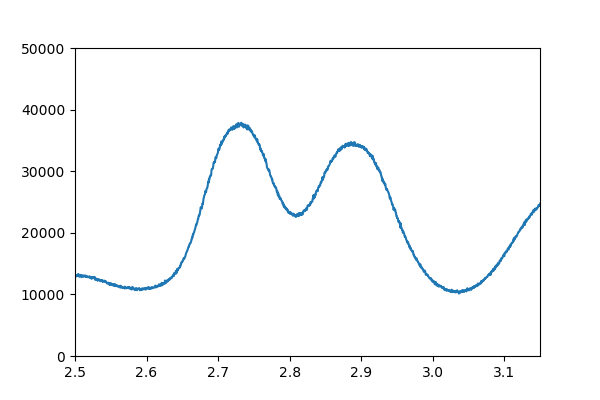

(0, 50000)

In [27]:
plt.figure(figsize=(6,4))
plt.plot(x, y)
plt.xlim(2.5,3.15)
plt.ylim(0, 50000)

<IPython.core.display.Javascript object>


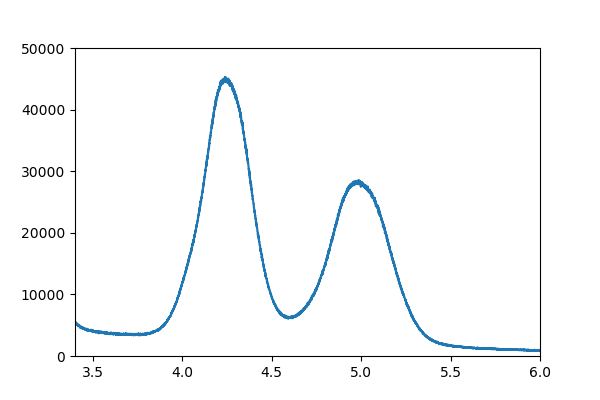

(0, 50000)

In [28]:
plt.figure(figsize=(6,4))
plt.plot(x, y)
plt.xlim(3.4,6.0)
plt.ylim(0, 50000)

<IPython.core.display.Javascript object>


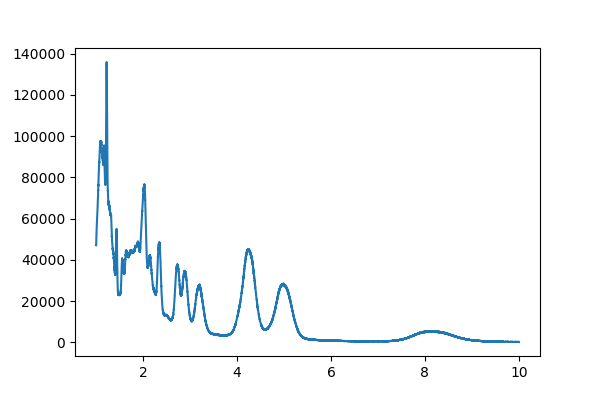

In [29]:
plt.figure(figsize=(6,4))
plt.plot(x, y)
# plt.xlim(3.4,6.0)
# plt.ylim(0, 50000)

It looks like the C60_RT.cif provides a structure that is consistent with the measured data.

The good d values are

In [30]:
good_d_values = [2.7251,2.8904,4.2694,5.0063,8.1753]

In [31]:
good_d_values = [2.72509327,  2.89039789, 4.26940063,  5.00631601, 8.17527981]